RANDOM FOREST MODEL WITH NO PRETRAINED AI MODEL

In [1]:
# Setting the path of the training dataset (that was already provided to you)
import os

running_local = True if os.getenv('JUPYTERHUB_USER') is None else False
DATASET_PATH = "."

# Set the location of the dataset
if running_local:
    # If running on your local machine, the sign_lang_train folder's path should be specified here
    local_path = os.path.join('..', '..', 'sign_lang_train')
    if os.path.exists(local_path):
        DATASET_PATH = local_path
else:
    # If running on the Jupyter hub, this data folder is already available
    # You DO NOT need to upload the data!
    DATASET_PATH = "/data/mlproject22/sign_lang_train"

In [2]:
import sys
print(sys.executable)

c:\Users\frala\OneDrive\Desktop\Important Documents\Innsbruck\University\Summer Semester - 2025\01 - Project\machine-learning-project\rf_venv\Scripts\python.exe


In [3]:
import csv
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from string import ascii_lowercase

# Utility function

def read_csv(csv_file):
    with open(csv_file, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
    return data

class SignLangDataset(Dataset):
    """Sign language dataset"""

    def __init__(self, csv_file, root_dir, class_index_map=None, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = read_csv(os.path.join(root_dir,csv_file))
        self.root_dir = root_dir
        self.class_index_map = class_index_map
        self.transform = transform
        # List of class names in order
        self.class_names = list(map(str, list(range(10)))) + list(ascii_lowercase)

    def __len__(self):
        """
        Calculates the length of the dataset-
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns one sample (dict consisting of an image and its label)
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Read the image and labels
        image_path = os.path.join(self.root_dir, self.data[idx][1])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # Shape of the image should be H,W,C where C=1
        image = np.expand_dims(image, 0)
        # The label is the index of the class name in the list ['0','1',...,'9','a','b',...'z']
        # because we should have integer labels in the range 0-35 (for 36 classes)
        label = self.class_names.index(self.data[idx][0])
                
        sample = {'image': image, 'label': label}

        #if self.transform:
        #    sample = self.transform(sample)

        return sample

IMPORT DATA

In [4]:
dataset = SignLangDataset("labels.csv", DATASET_PATH)

Image shape: (1, 128, 128)
Label: 21


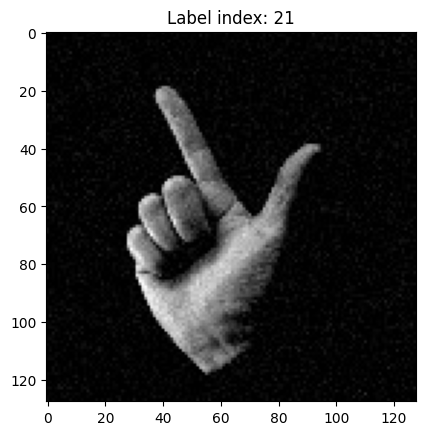

In [5]:
import matplotlib.pyplot as plt
sample = dataset[0]

print("Image shape:", sample['image'].shape)  # Should be (3, 224, 224)
print("Label:", sample['label'])              # Should be int between 0–35

image = sample['image'][0]  # Remove channel dim for display
label = sample['label']

plt.imshow(image, cmap='gray')
plt.title(f"Label index: {label}")
plt.show()

RANDOM FOREST REQUIRES 2D INPUT - FLATTEN THE IMAGES

In [6]:
import numpy as np

X = []
y = []

for sample in dataset:
    image = sample['image'].reshape(-1)  # flatten to (16384,)
    label = sample['label']
    X.append(image)
    y.append(label)

X = np.stack(X)  # shape: (9680, 16384)
y = np.array(y)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = RandomForestClassifier(n_estimators=150, n_jobs=-1, max_depth=None,           # allow deeper trees
    min_samples_leaf=1,)
clf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=150, n_jobs=-1)

In [9]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Test accuracy:", acc)

print("\nClassification report:\n")
print(classification_report(y_test, y_pred, digits=3))


Test accuracy: 0.7360537190082644

Classification report:

              precision    recall  f1-score   support

           0      0.756     0.911     0.826       112
           1      0.875     0.318     0.467        22
           2      0.667     0.091     0.160        22
           3      1.000     0.045     0.087        22
           4      0.664     0.848     0.745       112
           5      0.800     0.174     0.286        23
           6      0.602     0.893     0.719       112
           7      1.000     0.045     0.087        22
           8      1.000     0.147     0.256        34
           9      0.675     0.964     0.794       112
          10      0.429     0.136     0.207        22
          11      0.898     0.946     0.922        56
          12      0.871     0.964     0.915       112
          13      1.000     0.353     0.522        34
          14      1.000     0.478     0.647        23
          15      1.000     0.304     0.467        23
          16      0.80

c:\Users\frala\OneDrive\Desktop\Important Documents\Innsbruck\University\Summer Semester - 2025\01 - Project\machine-learning-project\rf_venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\frala\OneDrive\Desktop\Important Documents\Innsbruck\University\Summer Semester - 2025\01 - Project\machine-learning-project\rf_venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\frala\OneDrive\Desktop\Important Documents\Innsbruck\University\Summer Semester - 2025\01 - Project\machine-learning-

In [10]:
import sys
print(sys.version)

3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]


In [11]:
import joblib

joblib.dump(clf, "new_normal_rf.joblib", compress=3)

['new_normal_rf.joblib']

DECOMPRESS THE MODEL AND TRY TO USE IT AGAIN

In [25]:
decompressed_model = joblib.load("new_normal_rf.joblib")

y_pred = decompressed_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Test accuracy:", acc)

print("\nClassification report:\n")
print(classification_report(y_test, y_pred, digits=3))

Test accuracy: 0.7350206611570248

Classification report:

              precision    recall  f1-score   support

           0      0.739     0.938     0.827       112
           1      0.857     0.273     0.414        22
           2      1.000     0.136     0.240        22
           3      1.000     0.045     0.087        22
           4      0.651     0.848     0.736       112
           5      0.833     0.217     0.345        23
           6      0.575     0.857     0.688       112
           7      1.000     0.045     0.087        22
           8      1.000     0.118     0.211        34
           9      0.711     0.946     0.812       112
          10      0.375     0.136     0.200        22
          11      0.942     0.875     0.907        56
          12      0.902     0.982     0.940       112
          13      1.000     0.294     0.455        34
          14      1.000     0.565     0.722        23
          15      1.000     0.348     0.516        23
          16      0.79

c:\Users\frala\OneDrive\Desktop\Important Documents\Innsbruck\University\Summer Semester - 2025\01 - Project\machine-learning-project\rf_venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\frala\OneDrive\Desktop\Important Documents\Innsbruck\University\Summer Semester - 2025\01 - Project\machine-learning-project\rf_venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\frala\OneDrive\Desktop\Important Documents\Innsbruck\University\Summer Semester - 2025\01 - Project\machine-learning-

In [8]:
import numpy as np
import sklearn
import joblib
print("scikit-learn:", sklearn.__version__)
print("numpy:", np.__version__)
print("joblib:", joblib.__version__)

scikit-learn: 1.6.1
numpy: 1.26.4
joblib: 1.4.2
